In [1]:
# ------------------------------------------------------------
# 0. 라이브러리
# ------------------------------------------------------------
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import torch
from torch import nn

# ------------------------------------------------------------
# 1. 데이터 로드
# ------------------------------------------------------------
adata = sc.read_h5ad("Lung_cancer.h5ad")   # 당신의 파일 경로

# ------------------------------------------------------------
# 2. 기본 전처리
# ------------------------------------------------------------
sc.pp.filter_genes(adata, min_cells=3)            # 너무 희귀한 유전자 제거
adata.layers["counts"] = adata.X.copy()           # scvi가 raw‑counts 레이어 사용
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor="seurat_v3")
adata = adata[:, adata.var.highly_variable].copy()

# ------------------------------------------------------------
# 3. Train / Test Split
# ------------------------------------------------------------
rng = np.random.RandomState(42)
train_mask = rng.rand(adata.n_obs) < 0.8
adata_train = adata[train_mask].copy()
adata_test  = adata[~train_mask].copy()

# ------------------------------------------------------------
# 4. Dirichlet‑기반 pseudobulk 생성
# ------------------------------------------------------------
def dirichlet_pseudobulks(adata_in, n_bulk=500, cells_per_bulk=100, alpha=1.0):
    """
    adata_in : AnnData (train subset)  
    반환       : pseudobulk 포함 concat AnnData
    """
    cell_types = adata_in.obs["cell_type"].unique()
    obs_list   = []
    X_list     = []

    # 미리 index 배열 캐싱
    ct_indices = {ct: np.where(adata_in.obs["cell_type"].values == ct)[0] 
                  for ct in cell_types}
    α = np.full(len(cell_types), alpha)

    for i in range(n_bulk):
        props = np.random.dirichlet(α)
        picks = []
        for ct, p in zip(cell_types, props):
            n_ct = max(1, int(round(p * cells_per_bulk)))
            choice = rng.choice(ct_indices[ct], size=n_ct, replace=len(ct_indices[ct]) < n_ct)
            picks.extend(choice)

        Xpb = adata_in[picks].layers["counts"].sum(axis=0).A1   # 희소 → 1D ndarray
        X_list.append(Xpb)
        obs_list.append({"pseudo": True, "cell_type": "PB"})

    adata_pb = sc.AnnData(np.vstack(X_list), 
                          obs=pd.DataFrame(obs_list, 
                                           index=[f"PB{i}" for i in range(n_bulk)]),
                          var=adata_in.var.copy())
    adata_pb.layers["counts"] = adata_pb.X.copy()

    # concat(train + pb)
    adata_cat = sc.concat([adata_in, adata_pb], join="inner", 
                          label="batch_source", keys=["cell", "pseudo"])
    adata_cat.layers["counts"] = adata_cat.X.copy()
    return adata_cat

adata_train_pb = dirichlet_pseudobulks(adata_train, n_bulk=300, cells_per_bulk=80)

# ------------------------------------------------------------
# 5. MixupVI 정의 (scvi‑tools subclass)
# ------------------------------------------------------------
class MixupVI(scvi.model.SCVI):
    def __init__(self, adata, mixup_weight=1.0, cells_per_bulk=80, n_mix=64, **kwargs):
        super().__init__(adata, **kwargs)
        self.mixup_weight   = mixup_weight
        self.cells_per_bulk = cells_per_bulk
        self.n_mix          = n_mix

    # latent 선형성 강제 L2 penalty
    def _mixup_loss(self, x_batch, z_batch):
        B = x_batch.shape[0]
        device = x_batch.device
        mix_losses = []
        for _ in range(self.n_mix):
            idx = torch.randperm(B, device=device)[: self.cells_per_bulk]
            z_mean = z_batch[idx].mean(0, keepdim=True)
            x_sum  = x_batch[idx].sum(0, keepdim=True)
            z_pb   = self.module.encoder(x_sum)[0]           # q(z|x) mean
            mix_losses.append(((z_pb - z_mean) ** 2).sum(1))
        return torch.stack(mix_losses).mean()

    # loss override:  -ELBO + λ * mixup
    def loss(self, *_args, **kwargs):
        base_out = super().loss(*_args, **kwargs)            # 기본(-ELBO) 리턴
        x_b = kwargs["batch"]
        z_b = base_out["z"]                                  # latent sample
        mix_loss = self._mixup_loss(x_b, z_b)
        base_out["loss"] = base_out["loss"] + self.mixup_weight * mix_loss
        return base_out

# ----------------- MixupVI 세팅
MixupVI.setup_anndata(adata_train_pb, layer="counts")

# ----------------- 훈련
model = MixupVI(adata_train_pb,
                n_hidden=256, n_latent=20,
                mixup_weight=1.0, cells_per_bulk=80, n_mix=32)
model.train(max_epochs=50, plan_kwargs={"lr":1e-3})

# ------------------------------------------------------------
# 6. 임베딩 & k‑NN 라벨 전파
# ------------------------------------------------------------
train_latent = model.get_latent_representation(adata_train)
test_latent  = model.get_latent_representation(adata_test)

knn = NearestNeighbors(n_neighbors=10).fit(train_latent)
dists, idxs = knn.kneighbors(test_latent)

train_labels = adata_train.obs["cell_type"].values
majority = []
topk_tbl = []

for cell_i, neigh in enumerate(idxs):
    neigh_labels = train_labels[neigh]
    topk_tbl.append(neigh_labels)
    uniq, counts = np.unique(neigh_labels, return_counts=True)
    majority.append(uniq[np.argmax(counts)])

adata_test.obs["predicted_cell_type"] = majority
'''
pd.DataFrame(topk_tbl,
             index=adata_test.obs_names,
             columns=[f"knn_{k}" for k in range(1, 11)]
            ).to_csv("test_knn_neighbor_labels.csv")
'''

print("✅ Done — `predicted_cell_type` column이 test AnnData에 추가되었습니다.")


/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. 

Epoch 1/50:   0%|                                        | 0/50 [00:00<?, ?it/s]

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/50:   2%| | 1/50 [00:03<02:42,  3.31s/it, v_num=1, train_loss_step=266, 

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 3/50:   4%| | 2/50 [00:06<02:24,  3.01s/it, v_num=1, train_loss_step=315, 

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 4/50:   6%| | 3/50 [00:08<02:16,  2.91s/it, v_num=1, train_loss_step=344, 

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 5/50:   8%| | 4/50 [00:11<02:11,  2.87s/it, v_num=1, train_loss_step=450, 

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/50:  10%| | 5/50 [00:14<02:08,  2.86s/it, v_num=1, train_loss_step=293, 

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 7/50:  12%| | 6/50 [00:17<02:04,  2.83s/it, v_num=1, train_loss_step=308, 

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 8/50:  14%|▏| 7/50 [00:20<02:01,  2.83s/it, v_num=1, train_loss_step=290, 

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 9/50:  16%|▏| 8/50 [00:22<01:58,  2.83s/it, v_num=1, train_loss_step=394, 

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 10/50:  18%|▏| 9/50 [00:25<01:56,  2.85s/it, v_num=1, train_loss_step=288,

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 11/50:  20%|▏| 10/50 [00:28<01:53,  2.85s/it, v_num=1, train_loss_step=223

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 12/50:  22%|▏| 11/50 [00:31<01:51,  2.85s/it, v_num=1, train_loss_step=226

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 13/50:  24%|▏| 12/50 [00:34<01:48,  2.86s/it, v_num=1, train_loss_step=283

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 14/50:  26%|▎| 13/50 [00:37<01:45,  2.84s/it, v_num=1, train_loss_step=232

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 15/50:  28%|▎| 14/50 [00:40<01:42,  2.85s/it, v_num=1, train_loss_step=341

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 16/50:  30%|▎| 15/50 [00:42<01:39,  2.84s/it, v_num=1, train_loss_step=223

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 17/50:  32%|▎| 16/50 [00:45<01:36,  2.84s/it, v_num=1, train_loss_step=224

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 18/50:  34%|▎| 17/50 [00:48<01:33,  2.84s/it, v_num=1, train_loss_step=347

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 19/50:  36%|▎| 18/50 [00:51<01:30,  2.84s/it, v_num=1, train_loss_step=222

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 20/50:  38%|▍| 19/50 [00:54<01:28,  2.85s/it, v_num=1, train_loss_step=219

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 21/50:  40%|▍| 20/50 [00:57<01:25,  2.84s/it, v_num=1, train_loss_step=323

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 22/50:  42%|▍| 21/50 [00:59<01:22,  2.84s/it, v_num=1, train_loss_step=342

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 23/50:  44%|▍| 22/50 [01:02<01:19,  2.85s/it, v_num=1, train_loss_step=209

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 24/50:  46%|▍| 23/50 [01:05<01:17,  2.86s/it, v_num=1, train_loss_step=259

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 25/50:  48%|▍| 24/50 [01:08<01:14,  2.85s/it, v_num=1, train_loss_step=224

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 26/50:  50%|▌| 25/50 [01:11<01:11,  2.85s/it, v_num=1, train_loss_step=212

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 27/50:  52%|▌| 26/50 [01:14<01:08,  2.86s/it, v_num=1, train_loss_step=205

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 28/50:  54%|▌| 27/50 [01:17<01:05,  2.85s/it, v_num=1, train_loss_step=214

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 29/50:  56%|▌| 28/50 [01:19<01:02,  2.84s/it, v_num=1, train_loss_step=223

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 30/50:  58%|▌| 29/50 [01:22<00:59,  2.82s/it, v_num=1, train_loss_step=374

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 31/50:  60%|▌| 30/50 [01:25<00:56,  2.82s/it, v_num=1, train_loss_step=219

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 32/50:  62%|▌| 31/50 [01:28<00:53,  2.81s/it, v_num=1, train_loss_step=209

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 33/50:  64%|▋| 32/50 [01:31<00:50,  2.81s/it, v_num=1, train_loss_step=217

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 34/50:  66%|▋| 33/50 [01:33<00:47,  2.82s/it, v_num=1, train_loss_step=317

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 35/50:  68%|▋| 34/50 [01:36<00:45,  2.81s/it, v_num=1, train_loss_step=332

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 36/50:  70%|▋| 35/50 [01:39<00:42,  2.82s/it, v_num=1, train_loss_step=272

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 37/50:  72%|▋| 36/50 [01:42<00:39,  2.83s/it, v_num=1, train_loss_step=207

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 38/50:  74%|▋| 37/50 [01:45<00:36,  2.82s/it, v_num=1, train_loss_step=210

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 39/50:  76%|▊| 38/50 [01:48<00:33,  2.82s/it, v_num=1, train_loss_step=261

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 40/50:  78%|▊| 39/50 [01:50<00:31,  2.83s/it, v_num=1, train_loss_step=275

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 41/50:  80%|▊| 40/50 [01:53<00:28,  2.83s/it, v_num=1, train_loss_step=230

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 42/50:  82%|▊| 41/50 [01:56<00:25,  2.84s/it, v_num=1, train_loss_step=229

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 43/50:  84%|▊| 42/50 [01:59<00:22,  2.84s/it, v_num=1, train_loss_step=278

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 44/50:  86%|▊| 43/50 [02:02<00:19,  2.83s/it, v_num=1, train_loss_step=278

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 45/50:  88%|▉| 44/50 [02:05<00:16,  2.83s/it, v_num=1, train_loss_step=377

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 46/50:  90%|▉| 45/50 [02:07<00:14,  2.84s/it, v_num=1, train_loss_step=333

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 47/50:  92%|▉| 46/50 [02:10<00:11,  2.82s/it, v_num=1, train_loss_step=209

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 48/50:  94%|▉| 47/50 [02:13<00:08,  2.82s/it, v_num=1, train_loss_step=278

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 49/50:  96%|▉| 48/50 [02:16<00:05,  2.82s/it, v_num=1, train_loss_step=271

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 50/50:  98%|▉| 49/50 [02:19<00:02,  2.83s/it, v_num=1, train_loss_step=223

/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/jeongbinpark/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 50/50: 100%|█| 50/50 [02:22<00:00,  2.83s/it, v_num=1, train_loss_step=217

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|█| 50/50 [02:22<00:00,  2.84s/it, v_num=1, train_loss_step=217
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
✅ Done — `predicted_cell_type` column이 test AnnData에 추가되었습니다.


predicted_cell_type                        CD4-positive, alpha-beta memory T cell  \
cell_type                                                                           
epithelial cell of lung                                                         0   
granulocyte                                                                     0   
mast cell                                                                       0   
smooth muscle cell                                                              1   
macrophage                                                                      0   
natural killer cell                                                             2   
pericyte                                                                        0   
plasmacytoid dendritic cell                                                     1   
plasma cell                                                                     3   
classical monocyte                                               

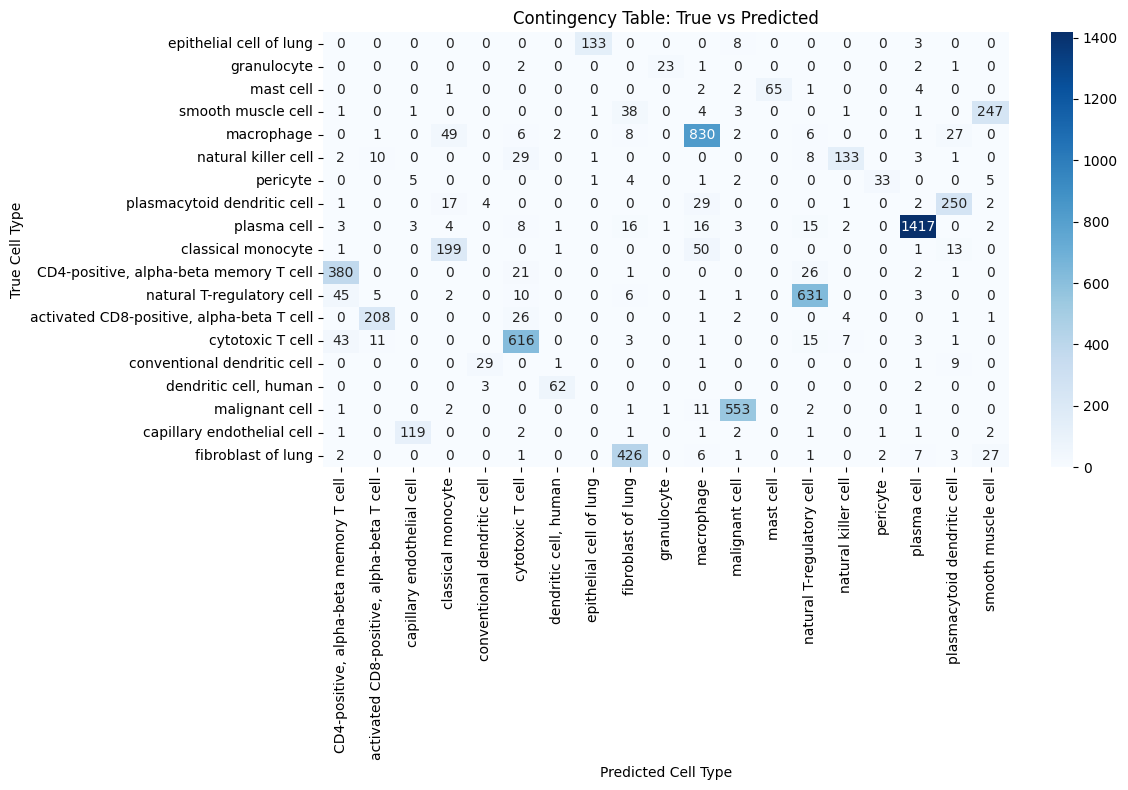

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 교차표 생성
ct_table = pd.crosstab(
    adata_test.obs["cell_type"],               # 실제 정답 (행)
    adata_test.obs["predicted_cell_type"]      # 예측값 (열)
)

# 표 출력
print(ct_table)

# 히트맵으로 시각화 (선택사항)
plt.figure(figsize=(12, 8))
sns.heatmap(ct_table, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Cell Type")
plt.ylabel("True Cell Type")
plt.title("Contingency Table: True vs Predicted")
plt.tight_layout()
plt.show()
